In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# line = " " 
# with open("results.csv", 'r') as f:
#     with open("results-new.csv", 'w') as fout:
#         while line != None:
#             # try:
#             line = f.readline()
#             if line[0:6] == "client":
#                 fout.write(line)
#             # except Exception as e:
#             #     f.seek()


In [3]:
df = pd.read_csv("results-new.csv", header=None, delimiter=' ', )
df

,0,1,2
0,client1,1701465886,26716
1,client1,1701465887,26668
2,client1,1701465888,26652
3,client1,1701465889,27184
4,client1,1701465890,26712
...,...,...,...
356521,client2,1701584738,31556
356522,client3,1701584738,31560
356523,client1,1701584739,31550
356524,client2,1701584739,31559


In [4]:
df['client'] = df[0]
df['sec'] = df[1]
df['ms'] = df[2]
df.drop(columns=[0,1,2], inplace=True)

In [5]:
df1 = df[df['client'] == "client1"]
df2 = df[df['client'] == "client2"]
df3 = df[df['client'] == "client3"]

In [6]:
start_time = df['sec'].min()
start_time

1701465886

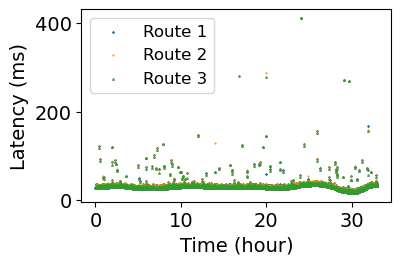

In [131]:
fig, ax = plt.subplots(1,1, figsize=(4,2.5))
ax.scatter((df1["sec"] - start_time)/3600, df1["ms"]/1000, s=1, marker='x', label='Route 1')
ax.scatter((df2["sec"] - start_time)/3600, df2["ms"]/1000, s=1, marker='.', label='Route 2')
ax.scatter((df3["sec"] - start_time)/3600, df3["ms"]/1000, s=1, marker='^', label='Route 3')
ax.legend(fontsize=12)
ax.set_xlabel('Time (hour)', fontsize=14)
ax.set_ylabel('Latency (ms)', fontsize=14)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# ax.set_title('The Distribution of Latency between Two Data Centers')
fig.savefig('latency.png', bbox_inches='tight')

In [8]:
df[df['ms'] > 100000].count() / df.count()
np.percentile(df['ms'], [0.1, 99, 99.9, 99.99])

df.count()

client    356526
sec       356526
ms        356526
dtype: int64

In [9]:
df12 = df2.merge(df1, on="sec")
df123 = df12.merge(df3, on='sec')
# df123['maxdiff'] = df.apply(lambda row: max(np.abs(row['ms_x'] - row['ms_y']), np.abs(row['ms_x'] - row['ms']), np.abs(row['ms'] - row['ms_y'])))
df123['maxdiff'] = np.maximum.reduce([
    np.abs(df123['ms_x'] - df123['ms_y']),
    np.abs(df123['ms_x'] - df123['ms']),
    np.abs(df123['ms'] - df123['ms_y'])
])
np.percentile(df123['maxdiff'], [0.1, 99, 99.9, 99.99])


array([6.0000000e+00, 1.3000000e+02, 4.3076520e+03, 7.1578541e+03])

In [65]:
alpha=0.3
beta=6
p_normal=0.999
t_inter = 4310

s_pen = 1 / beta
s_awd = 1/alpha * s_pen * (1-p_normal) / p_normal

s_pen, s_awd

(0.16666666666666666, 0.0005561116672227788)

In [66]:
df123['agreed'] = np.minimum.reduce([df123['ms_y'], df123['ms_x'], df123['ms']]) + t_inter
df123['score_change_1'] = np.where(df123['ms_x'] < df123['agreed'], s_awd, -s_pen)
df123['score_change_2'] = np.where(df123['ms_y'] < df123['agreed'], s_awd, -s_pen)
df123['score_change_3'] = np.where(df123['ms'] < df123['agreed'], s_awd, -s_pen)
df123

,client_x,sec,ms_x,client_y,ms_y,client,ms,maxdiff,agreed,score_change_1,score_change_2,score_change_3
0,client2,1701465894,26557,client1,26552,client3,26500,57,30810,0.000556,0.000556,0.000556
1,client2,1701465895,26543,client1,26537,client3,26471,72,30781,0.000556,0.000556,0.000556
2,client2,1701465896,26590,client1,26584,client3,26518,72,30828,0.000556,0.000556,0.000556
3,client2,1701465897,26707,client1,26698,client3,26748,50,31008,0.000556,0.000556,0.000556
4,client2,1701465898,26536,client1,26531,client3,26492,44,30802,0.000556,0.000556,0.000556
...,...,...,...,...,...,...,...,...,...,...,...,...
118833,client2,1701584735,31565,client1,31556,client3,31569,13,35866,0.000556,0.000556,0.000556
118834,client2,1701584736,31573,client1,31564,client3,31577,13,35874,0.000556,0.000556,0.000556
118835,client2,1701584737,31563,client1,31555,client3,31567,12,35865,0.000556,0.000556,0.000556
118836,client2,1701584738,31556,client1,31547,client3,31560,13,35857,0.000556,0.000556,0.000556


In [67]:
def score_trend(sc):
    trend = [1]
    cur = 1
    for change in sc:
        cur+=change
        if cur > 1:
            cur = 1
        trend.append(cur)
    return trend


In [68]:
sc1 = df123['score_change_1']
sc2 = df123['score_change_2']
sc3 = df123['score_change_3']

s1 = score_trend(sc1)
s2 = score_trend(sc2)
s3 = score_trend(sc3)

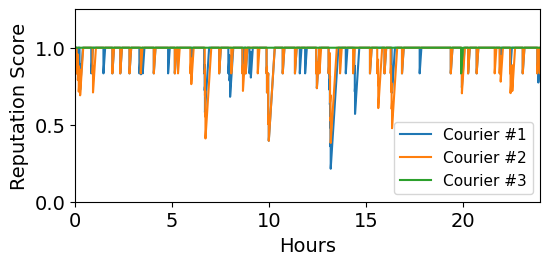

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(6,2.5))
xaxis = np.arange(len(s1))/3600
ax.plot(xaxis, s1, label='Courier #1')
ax.plot(xaxis, s2, label='Courier #2')
ax.plot(xaxis, s3, label='Courier #3')
ax.set_ylim(0, 1.25)
ax.set_xlim(0,24)
ax.legend(fontsize=11)
# ax.set_title('The reputation change of three couriers')
ax.set_xlabel('Hours', fontsize=14)
ax.set_ylabel('Reputation Score', fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
fig.savefig('score-change.pdf', bbox_inches='tight')